In [1]:
# %load_ext autoreload
# %autoreload 2
from covid_constants_and_util import *
import helper_methods_for_aggregate_data_analysis as helper
from model_experiments import *
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

Setting numpy cores to 1
Running code on Deep; at Stanford=False


In [2]:
min_datetime = datetime.datetime(2020, 11, 30)  
max_datetime = datetime.datetime(2021, 4, 5)
dates = helper.list_datetimes_in_range(min_datetime, max_datetime)
print('Num dates', len(dates))
s = datetime.datetime(2020, 12, 20)  # start date for the SEIR parameters  # Would be the file name. 
# E.g.: /media/gpu/easystore/all_aggregate_data/seir_init/all_cbgs_s=2021-01-25.csv

Num dates 127


In [76]:
# load county-level ACS and NYT data
acs_5yr = pd.read_csv(PATH_TO_ACS_5YR_DATA)  
# /media/gpu/easystore/covid_mobility_results/new_census_data/ACS_2019_5YR_BG/ACS_race_cbsa_income_2019.csv

acs_5yr['census_block_group'] = acs_5yr['GEOID'].str[-12:]
acs_5yr['fips'] = acs_5yr['census_block_group'].str[:5]

print("Row count in acs_5yr:", len(acs_5yr))

acs_counties = acs_5yr.fips.unique()
print(len(acs_counties))
# acs_5yr['id_to_match_to_safegraph_data'] = acs_5yr['GEOID'].map(lambda x:x.split("US")[1]).astype(int)
acs_5yr['id_to_match_to_safegraph_data'] = acs_5yr['GEOID'].str[-12:]   # Huan
#acs_5yr['fips'] = get_fips_codes_from_state_and_county_fp(acs_5yr.STATEFP, acs_5yr.COUNTYFP)
#acs_5yr['fips'] = acs_5yr['fips'].astype(str).str.zfill(5)

acs_data = helper.load_and_reconcile_multiple_acs_data()  # Acutally the 2019 5-year ACS data. Huan
len(acs_counties)

Row count in acs_5yr: 219216
3220


3220

In [77]:
acs_5yr['county_state_name'] = acs_5yr['COUNTY_NAME']  + ', ' + acs_5yr['STATE_NAME']

In [78]:
acs_5yr['census_block_group'] = acs_5yr['GEOID'].str[-12:]

In [39]:
len(acs_5yr['county_state_name'].unique())

3220

In [40]:
len(acs_5yr['county_state_name'].unique())

3220

In [41]:
len(acs_5yr['county_code'].unique())

3220

In [42]:
acs_5yr.dtypes

OBJECTID                                      float64
STATEFP                                         int64
COUNTYFP                                        int64
TRACTCE                                         int64
BLKGRPCE                                        int64
INTPTLAT                                      float64
INTPTLON                                      float64
Shape_Area                                    float64
GEOID_Data                                     object
county_code                                     int64
COUNTY_NAME                                    object
STATE_ABB                                      object
STATE_NAME                                     object
cbg_total_population                            int64
p_asian                                       float64
p_black                                       float64
p_white                                       float64
CBSA Code                                     float64
CSA Code                    

In [43]:
acs_data['census_block_group'] = acs_5yr['fips']

In [44]:

cbgs_to_census_pops = dict(zip(acs_5yr['census_block_group'].values,
                            #acs_data['total_cbg_population_2018_1YR'].values))  # use most recent population data
                            acs_5yr['cbg_total_population'].values))  #  Huan
county2cbgs = {}
for county in acs_counties:
    county_cbgs = acs_5yr[acs_5yr.fips == county]['id_to_match_to_safegraph_data'].values
    pop_sizes = [cbgs_to_census_pops[c] for c in county_cbgs]
    county2cbgs[county] = (county_cbgs, pop_sizes)

nyt_outcomes = get_nyt_outcomes_over_counties()
nyt_counties = nyt_outcomes.fips.unique()
overlap_counties = set(acs_counties).intersection(set(nyt_counties))
print('Found %d counties in ACS 5-year; %d counties in NYT -> %d overlap' % 
      (len(acs_counties), len(nyt_counties), len(overlap_counties)))
nyt_outcomes.head()

Found 3220 counties in ACS 5-year; 3219 counties in NYT -> 3211 overlap


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0


In [45]:
nyt_outcomes

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0
...,...,...,...,...,...,...
1683403,2021-09-03,Sweetwater,Wyoming,56037,5791,49.0
1683404,2021-09-03,Teton,Wyoming,56039,4502,11.0
1683405,2021-09-03,Uinta,Wyoming,56041,3053,15.0
1683406,2021-09-03,Washakie,Wyoming,56043,1079,27.0


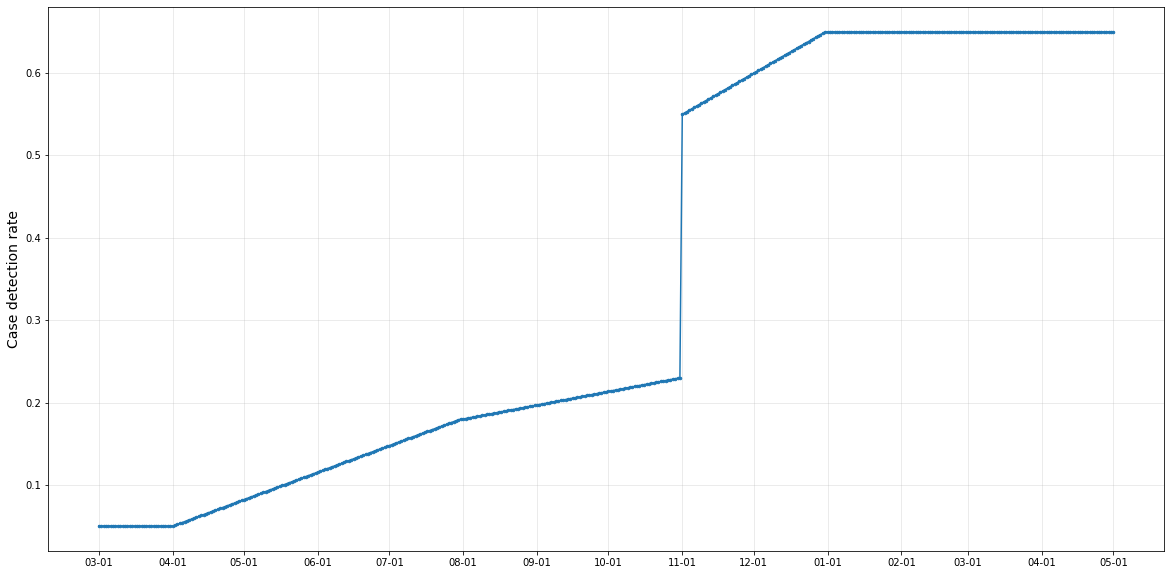

In [46]:
all_dates, all_rates = helper.get_daily_case_detection_rate()  # based on IHME estimate
fig, ax = plt.subplots(figsize=(20,10))
ax.plot_date(all_dates, all_rates, marker='.', markersize=5, linestyle='-')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_ylabel('Case detection rate', fontsize=14)
ax.tick_params(labelsize=10)
ax.grid(alpha=0.3)
plt.show()

In [88]:
def get_seir_at_given_time(s, county, nyt_outcomes, county2cbgs, dates, rate_over_time, mode='cases', verbose=False):
    assert mode in {'cases', 'deaths'}
    county_df = nyt_outcomes[nyt_outcomes.fips == county]  # process data of this county: 
    county_name = county_df.iloc[0]['county']
    state = county_df.iloc[0]['state']
    cbgs, pop_sizes = county2cbgs[county]
    if mode == 'deaths':
        lag = datetime.timedelta(days=DEATH_LAG)   # 18 days
    else:
        lag = datetime.timedelta(days=DETECTION_LAG)  # 9 days
    reported_dates = helper.list_datetimes_in_range(dates[0]+lag, dates[-1]+lag)  
    hours = helper.list_hours_in_range(dates[0], dates[-1]+datetime.timedelta(hours=23))
    assert len(hours) == (len(dates) * 24)
    assert s in hours
    
    # get cumulative and daily counts for county
    cumulative_counts = []
    first_date = np.min(county_df.date)
    for date in reported_dates:
        date_str = date.strftime('%Y-%m-%d')
        sub_df = county_df[county_df.date == date_str]
        if date_str < first_date:  # no data yet, assume count is 0
            cumulative_counts.append(0)
        elif len(sub_df) > 0:
            assert len(sub_df) == 1
            cumulative_counts.append(sub_df.iloc[0][mode])
        else:
            cumulative_counts.append(np.nan)
        # 
        
    cumulative_counts = np.array(cumulative_counts)
    # print("cumulative_counts:", cumulative_counts)
    num_nans = np.sum(np.isnan(cumulative_counts))
    if num_nans > 0:  # this will print if there is a break in data
        print('%s, %s: missing %s data for %d dates' % (county_name, state, mode, num_nans))
    daily_counts = get_daily_from_cumulative(np.array(cumulative_counts))
    # print(f"daily_counts: {daily_counts}")
    # using np.nanmean will get rid of nans, unless the entire 2-week period is nan
    smoothed_daily_counts = apply_smoothing(daily_counts, before=7, after=7, agg_func=np.nanmean)  # apply 2-week smoothing
    # print("smoothed_daily_counts:", smoothed_daily_counts)
    if verbose:
        # print(f"smoothed_daily_counts: {smoothed_daily_counts}")
        print(f"reported_dates: {reported_dates[0]}, {date_str}, case: {sub_df.iloc[0][mode]}")
        fig, ax = plt.subplots(figsize=(7,5))
        ax.plot_date(reported_dates, daily_counts, marker='x', color='grey')
        ax.plot_date(reported_dates, smoothed_daily_counts, marker='.', linestyle='-', color='orange')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_ylabel('Daily %s' % mode)
        ax.set_title(county_name)
        plt.show()
        
    assert len(smoothed_daily_counts) == len(rate_over_time)
    daily_E_to_I = smoothed_daily_counts / rate_over_time   # scale by time-varying rate
    # print(f"smoothed_daily_counts: {smoothed_daily_counts}")
    # print(f"rate_over_time: {rate_over_time}")
    # print(f'county: {county}, daily_E_to_I: {daily_E_to_I}')
    if verbose:
        
        fig, ax = plt.subplots(figsize=(7,5))
        ax.plot_date(dates, daily_E_to_I, marker='.', linestyle='-', color='blue')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.SU, interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_ylabel('Daily E->I')
        ax.set_title(f"{county}, {county_name}")
        plt.show()
    
    hourly_E_to_I = np.zeros(len(hours))  # convert daily to hourly
    for t in range(len(hourly_E_to_I)):
        d = int(t/24)
        hourly_E_to_I[t] = daily_E_to_I[d] / 24  # assume 1/24 of daily count happened in each hour
    s_index = hours.index(s)
    latency_period = int(LATENCY_PERIOD_IN_DAYS * 24)  # in hours, 4 days
    infectious_period = int(INFECTIOUS_PERIOD_IN_DAYS * 24)
    E = hourly_E_to_I * latency_period  # MLE
    # print(f"hourly_E_to_I: {hourly_E_to_I}")
    # print(f"E.shape: {E.shape}, E: {E} ")
    E_s = E[s_index]
    I_s = E[s_index - latency_period] 
    # assume I is same as E but translated by latency_period
    # Thus, the s_index should > latency_period, otherwise it will be negetive.
    # s_index should be at least 4 days after the mobility network
    
    # print(f"s_index: {s_index} , latency_period: {latency_period}")
    # print(f"I_s: {I_s}  ")
    # at time s, everything that entered I before s - infectious_period will have made it to R
    # lag = datetime.timedelta(days=RECOVERY_PEIROD_IN_DAYS)
    lag_one_day = datetime.timedelta(days=1)
    starting_date = helper.list_datetimes_in_range(dates[0] , dates[0]  + lag_one_day)[0]    # s_: starting
    date_str = s.strftime('%Y-%m-%d')
    starting_df = county_df[county_df.date == date_str]
    starting_date_cumulative_cases = starting_df.iloc[0]['cases']
    confirmed_removed = starting_date_cumulative_cases

    
    # R_s = np.sum(hourly_E_to_I[:s_index - infectious_period]) + cumulative_counts[0]   # Tempary solution! Huan
    R_s = confirmed_removed / rate_over_time.mean() # Tempary solution! Huan
    # print("rate_over_time.mean():", rate_over_time.mean())
    total_pop = np.sum(pop_sizes)
    S_s = total_pop - E_s - I_s - R_s
    verbose = True
    if verbose:
        print(f"starting_date: {s}, starting_df[0]['cases']: {starting_date_cumulative_cases}")
        print(f"s_index: {s_index}, R: {R_s}")
        # print(f"E.shape: {E.shape}, E: {E} ")
        print(f"Total population: {total_pop}")
        print('State of %s on %s: S = %.1f%%; E = %.1f%%; I = %.1f%%; R = %.1f%%' % 
              ((county_name + "," + state).rjust(30), s.strftime('%Y-%m-%d'), 
               100. * S_s / total_pop, 100 * E_s / total_pop, 100. * I_s / total_pop, 100. * R_s / total_pop))
    return S_s, E_s, I_s, R_s

In [89]:
# SEIR estimates based on cases
_, cdr_over_time = helper.get_daily_case_detection_rate(min_datetime=min_datetime, max_datetime=max_datetime)
cases_county2seir = {}
# print("overlap_counties:", overlap_counties)
Columbia_MSA_fips = ['45081', '45017', '45063', '45055', '45039', '45079']
for i, county in enumerate(sorted(overlap_counties)):  # sort by fips - will naturally sort by state
    
#     if county not in Columbia_MSA_fips:
#         continue
    print()
    cases_county2seir[county] = get_seir_at_given_time(s, county, nyt_outcomes, county2cbgs, dates, 
                                                       cdr_over_time, mode='cases', verbose=False)
    if i % 100 == 0:
        print('CHECKPOINT: finished processing %d counties!' % (i+1))


starting_date: 2020-12-20 00:00:00, starting_df[0]['cases']: 3741
s_index: 480, R: 5813.602806216091
Total population: 55380
State of                Autauga,Alabama on 2020-12-20: S = 88.4%; E = 0.6%; I = 0.5%; R = 10.5%
CHECKPOINT: finished processing 1 counties!

starting_date: 2020-12-20 00:00:00, starting_df[0]['cases']: 11827
s_index: 480, R: 18379.438756780997
Total population: 212830
State of                Baldwin,Alabama on 2020-12-20: S = 90.4%; E = 0.5%; I = 0.5%; R = 8.6%

starting_date: 2020-12-20 00:00:00, starting_df[0]['cases']: 1336
s_index: 480, R: 2076.17571481013
Total population: 25361
State of                Barbour,Alabama on 2020-12-20: S = 91.1%; E = 0.4%; I = 0.3%; R = 8.2%

starting_date: 2020-12-20 00:00:00, starting_df[0]['cases']: 1613
s_index: 480, R: 2506.6402904107335
Total population: 22493
State of                   Bibb,Alabama on 2020-12-20: S = 87.7%; E = 0.6%; I = 0.6%; R = 11.1%

starting_date: 2020-12-20 00:00:00, starting_df[0]['cases']: 4218


In [90]:
# convert county-level to CBG-level
mode = 'cases'
county2seir = cases_county2seir#.dropna()
rows = []


for i, county in enumerate(sorted(overlap_counties)):  # each county
    county_name = nyt_outcomes[nyt_outcomes.fips == county].iloc[0]['county']
    county_state = nyt_outcomes[nyt_outcomes.fips == county].iloc[0]['state']
    cbgs, popsizes = county2cbgs[county]
    total_pop = np.sum(popsizes)  # county pop size
    if i % 100 == 99:
        print('CHECKPOINT: finished processing %d counties!' % (i+1))
    seir = county2seir[county]
    if np.sum(np.isnan(seir)) > 0:
        print('Skipping %s, %s (%d CBGs) bc of nan SEIR' % (county_name, county_state, len(cbgs)))
    else:
        for cbg, cbg_pop in zip(cbgs, popsizes):
            row = {'census_block_group':cbg, 'county_fips':county, 'county_name':county_name, 'state':county_state}
            curr_sum = 0
            for i, state in enumerate(['E', 'I', 'R']):
                prop_in_state = seir[i+1] / total_pop  # assume CBGs within county have the same proportions
                num_in_state = int(round(cbg_pop * prop_in_state, 0))
                row['%s_%s' % (mode, state)] = num_in_state
                curr_sum += num_in_state
            row['%s_S' % mode] = cbg_pop - curr_sum  # do this to make sure it sums to population size; otherwise,
                                                     # rounding might throw things off
            # print(row)
            assert len(row) == 8
            rows.append(row)
print('Processed %d CBGs' % len(rows))

CHECKPOINT: finished processing 100 counties!
CHECKPOINT: finished processing 200 counties!
CHECKPOINT: finished processing 300 counties!
CHECKPOINT: finished processing 400 counties!
CHECKPOINT: finished processing 500 counties!
CHECKPOINT: finished processing 600 counties!
CHECKPOINT: finished processing 700 counties!
CHECKPOINT: finished processing 800 counties!
CHECKPOINT: finished processing 900 counties!
CHECKPOINT: finished processing 1000 counties!
CHECKPOINT: finished processing 1100 counties!
CHECKPOINT: finished processing 1200 counties!
CHECKPOINT: finished processing 1300 counties!
CHECKPOINT: finished processing 1400 counties!
CHECKPOINT: finished processing 1500 counties!
CHECKPOINT: finished processing 1600 counties!
CHECKPOINT: finished processing 1700 counties!
CHECKPOINT: finished processing 1800 counties!
CHECKPOINT: finished processing 1900 counties!
CHECKPOINT: finished processing 2000 counties!
CHECKPOINT: finished processing 2100 counties!
CHECKPOINT: finished p

In [91]:
cols = ['census_block_group', 'county_fips', 'county_name', 'state',
        'cases_S', 'cases_E', 'cases_I', 'cases_R']
df = pd.DataFrame(rows)[cols]
fn = os.path.join(PATH_TO_SEIR_INIT, 'all_cbgs_s=%s.csv' % (s.strftime('%Y-%m-%d')))
print(fn)
df.to_csv(fn, index=False)

/media/gpu/easystore/all_aggregate_data/seir_init/all_cbgs_s=2020-12-20.csv


# Read the model

In [2]:
# read d fitted modelto see what is happened

import json
import pickle

pkl = r'/media/gpu/easystore/extra_safegraph_aggregate_models/full_models/fitted_model_2021_10_27_13_18_33_059523_calibrate_r0_calibrate_r0.pkl'

fitted_model = pickle.load(open(pkl, 'rb'))

# print("attributes:", getattr(fitted_model))

model_results_to_save_separately = {}
for attr_to_save_separately in ['estimated_R0']:
# for attr_to_save_separately in ['history', 'CBGS_TO_IDXS', 'estimated_R0']:

    model_results_to_save_separately[attr_to_save_separately] = getattr(fitted_model, attr_to_save_separately)
    print(getattr(fitted_model, attr_to_save_separately))

{'R0': array([2.77777778, 2.45      , 2.63013699, 2.26315789, 2.5308642 ,
       2.89393939, 2.75675676, 2.34782609, 2.52054795, 2.26315789,
       3.08      , 1.953125  , 2.3030303 , 2.56666667, 2.47761194,
       2.51515152, 2.17808219, 2.21212121, 2.45901639, 2.95588235,
       2.41428571, 2.07407407, 2.90277778, 2.15254237, 1.86885246,
       2.96923077, 3.04285714, 2.68852459, 2.69620253, 3.06944444]), 'R0_base': array([0.04761905, 0.125     , 0.1369863 , 0.10526316, 0.0617284 ,
       0.07575758, 0.05405405, 0.05797101, 0.1369863 , 0.06578947,
       0.08      , 0.0625    , 0.10606061, 0.06666667, 0.07462687,
       0.04545455, 0.05479452, 0.04545455, 0.06557377, 0.07352941,
       0.04285714, 0.04938272, 0.08333333, 0.05084746, 0.        ,
       0.04615385, 0.07142857, 0.03278689, 0.18987342, 0.04166667]), 'R0_POI': array([2.73015873, 2.325     , 2.49315068, 2.15789474, 2.4691358 ,
       2.81818182, 2.7027027 , 2.28985507, 2.38356164, 2.19736842,
       3.        , 1.890625  ,

In [549]:
pkl = r'/media/gpu/easystore/covid-mobility-tool/Deep_configs.pkl'
configs = pickle.load(open(pkl, 'rb'))

len(configs)

1050

In [550]:
configs[15]

{'data_kwargs': {'MSA_name': 'Columbia_SC', 'nrows': None},
 'model_kwargs': {'min_datetime': datetime.datetime(2020, 12, 28, 0, 0),
  'max_datetime': datetime.datetime(2021, 1, 17, 23, 0),
  'exogenous_model_kwargs': {'home_beta': [0.01778888888888889,
    0.02134666666666667],
   'poi_psi': 128.57142857142858,
   'p_sick_at_t0': None,
   'inter_cbg_gamma': None,
   'just_compute_r0': False},
  'model_init_kwargs': {'num_seeds': 30},
  'simulation_kwargs': {'use_aggregate_mobility': False,
   'use_home_proportion_beta': False,
   'use_inter_cbg_leak_factor': False},
  'poi_attributes_to_clip': {'clip_areas': True,
   'clip_dwell_times': True,
   'clip_visits': True},
  'include_cbg_prop_out': False,
  'include_inter_cbg_travel': False,
  'include_mask_use': True},
 'experiment_to_run': 'normal_grid_search',
 'version': 'v2'}

In [7]:
fitted_model.keys()

dict_keys(['loss_dict', 'agg_county_loss_dict', 'per_county_loss_dict', 'clipping_monitor', 'final infected fraction', 'estimated_R0', 'intervention_cost'])

In [ ]:
fitted_model['']

In [4]:
import glob
# fitted_models = glob.glob(r'/media/gpu/easystore/extra_safegraph_aggregate_models/full_models/*calibrate_r0.pkl')
fitted_models = glob.glob(r'/media/gpu/easystore/extra_safegraph_aggregate_models/fast_to_load_results_only/*calibrate_r0.pkl')

for pkl in fitted_models[:1]:

    fitted_model = pickle.load(open(pkl, 'rb'))
    print(fitted_model)
    # R0 = fitted_model.estimated_R0['R0'].mean()
    # if R0 > 3:
    #     continue
    # print(f'R0: {R0:.3f}', )
    # print("self.HOME_BETA:", fitted_model.HOME_BETA, "PSI:", fitted_model.PSI)

{'loss_dict': {'eval_start_time_cases': datetime.datetime(2020, 12, 29, 0, 0), 'eval_end_time_cases': datetime.datetime(2021, 4, 12, 0, 0), 'cumulative_predicted_cases': array([[  0.6,  16.8,  39.6, ..., 310.2, 310.2, 310.2],
       [  0.6,  21. ,  47.4, ..., 279.6, 279.6, 279.6],
       [  1.2,  25.8,  66.6, ..., 288.6, 288.6, 288.6],
       ...,
       [  1.2,  22.2,  58.2, ..., 268.2, 268.2, 268.2],
       [  0.6,  19.8,  42. , ..., 231. , 231. , 231. ],
       [  0. ,  18. ,  40.2, ..., 248.4, 248.4, 248.4]]), 'cumulative_true_cases': array([48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772,
       54672, 55610, 56401, 56895, 57358, 57543, 58424, 59417, 60158,
       61248, 62273, 62841, 63174, 63760, 64374, 64942, 65833, 66596,
       67026, 67375, 67993, 68499, 69142, 69862, 70442, 70784, 71136,
       71537, 72040, 72743, 73225, 73756, 74150, 74442, 74832, 75306,
       75973, 76526, 77180, 77571, 77830, 78171, 78686, 79288, 80030,
       80724, 81020, 81372, 81793, 

In [3]:

# load configs

import glob
fitted_models = glob.glob(r'/media/gpu/easystore/extra_safegraph_aggregate_models/data_and_model_configs/*normal_grid_search.pkl')


for pkl in fitted_models:

    fitted_model = pickle.load(open(pkl, 'rb'))
    R0 = fitted_model.estimated_R0['R0'].mean()
    if R0 > 3:
        continue
    print(f'R0: {R0:.3f}', )
    print("self.HOME_BETA:", fitted_model.HOME_BETA, "PSI:", fitted_model.PSI)

AttributeError: 'dict' object has no attribute 'estimated_R0'

In [16]:
fitted_model

{'model_kwargs': {'min_datetime': datetime.datetime(2021, 1, 1, 0, 0),
  'max_datetime': datetime.datetime(2021, 1, 17, 23, 0),
  'exogenous_model_kwargs': {'home_beta': array([0.00452222, 0.00455049, 0.00457875, 0.00460701, 0.00463528,
          0.00466354, 0.00469181, 0.00472007, 0.00474833, 0.0047766 ,
          0.00480486, 0.00483313, 0.00486139, 0.00488965, 0.00491792,
          0.00494618, 0.00497444]),
   'poi_psi': 414.2857142857143,
   'p_sick_at_t0': None,
   'inter_cbg_gamma': None,
   'just_compute_r0': False},
  'model_init_kwargs': {'num_seeds': 30},
  'simulation_kwargs': {'use_aggregate_mobility': False,
   'use_home_proportion_beta': False,
   'use_inter_cbg_leak_factor': False},
  'poi_attributes_to_clip': {'clip_areas': True,
   'clip_dwell_times': True,
   'clip_visits': True},
  'include_cbg_prop_out': False,
  'include_inter_cbg_travel': False,
  'include_mask_use': True,
  'counties_to_track': ['45055', '45063', '45039', '45081', '45079', '45017'],
  'poi_cbg_vis

# Fast load models

In [25]:

# fast load moudels

import glob
import pickle
fitted_models = glob.glob(r'/media/gpu/easystore/extra_safegraph_aggregate_models/fast_to_load_results_only/*2021_11_26_*_*normal_grid_search.pkl')

for pkl in fitted_models:

    fitted_model = pickle.load(open(pkl, 'rb'))
    
    daily_cases_RMSE = fitted_model['loss_dict']['daily_cases_RMSE']
    if daily_cases_RMSE < 400:

        print("fitted_model['loss_dict']['daily_cases_RMSE']:", daily_cases_RMSE)

fitted_model['loss_dict']['daily_cases_RMSE']: 369.23944299202657
fitted_model['loss_dict']['daily_cases_RMSE']: 348.83505210362256
fitted_model['loss_dict']['daily_cases_RMSE']: 354.57824949506943
fitted_model['loss_dict']['daily_cases_RMSE']: 395.6170089434887
fitted_model['loss_dict']['daily_cases_RMSE']: 365.9154862288762
fitted_model['loss_dict']['daily_cases_RMSE']: 350.68503343848823
fitted_model['loss_dict']['daily_cases_RMSE']: 370.1110505781167
fitted_model['loss_dict']['daily_cases_RMSE']: 376.08412325545316
fitted_model['loss_dict']['daily_cases_RMSE']: 376.3270635810111
fitted_model['loss_dict']['daily_cases_RMSE']: 385.9851156539591
fitted_model['loss_dict']['daily_cases_RMSE']: 394.80676889349786
fitted_model['loss_dict']['daily_cases_RMSE']: 385.7336585794674
fitted_model['loss_dict']['daily_cases_RMSE']: 351.38544174805577
fitted_model['loss_dict']['daily_cases_RMSE']: 394.4876703128796
fitted_model['loss_dict']['daily_cases_RMSE']: 350.69684254019984
fitted_model['los

In [14]:
fitted_model.keys()

dict_keys(['loss_dict', 'agg_county_loss_dict', 'per_county_loss_dict', 'clipping_monitor', 'final infected fraction', 'estimated_R0', 'intervention_cost'])

In [20]:
fitted_model['loss_dict'] 

{'eval_start_time_cases': datetime.datetime(2020, 12, 29, 0, 0),
 'eval_end_time_cases': datetime.datetime(2021, 2, 7, 0, 0),
 'cumulative_predicted_cases': array([[ 43060.8,  49443.6,  75219. , ..., 485179.8, 485198.4, 485210.4],
        [ 42637.8,  49111.8,  74739.6, ..., 485175.6, 485195.4, 485209.8],
        [ 42631.2,  49171.8,  75204.6, ..., 485181. , 485194.8, 485206.8],
        ...,
        [ 43001.4,  49387.8,  74866.8, ..., 485175. , 485186.4, 485195.4],
        [ 43279.8,  49801.8,  75819. , ..., 485180.4, 485197.2, 485209.8],
        [ 42787.8,  49367.4,  75203.4, ..., 485172.6, 485194.8, 485206.2]]),
 'cumulative_true_cases': array([48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772,
        54672, 55610, 56401, 56895, 57358, 57543, 58424, 59417, 60158,
        61248, 62273, 62841, 63174, 63760, 64374, 64942, 65833, 66596,
        67026, 67375, 67993, 68499, 69142, 69862, 70442, 70784, 71136,
        71537, 72040, 72743, 73225, 73756]),
 'cumulative_cases_RMSE':

In [7]:
fitted_model['final infected fraction']

array([0.80361578, 0.79851969, 0.80529275, 0.80324215, 0.80109597,
       0.80543467, 0.80267882, 0.80018942, 0.80278743, 0.80375191,
       0.79782891, 0.80256731, 0.8010699 , 0.79973904, 0.79882525,
       0.80147394, 0.80286853, 0.80053264, 0.80200397, 0.80239208,
       0.80256876, 0.80433552, 0.79900192, 0.80220382, 0.79975207,
       0.79828653, 0.80115969, 0.80185626, 0.80410526, 0.7994581 ])

In [9]:
import scipy
import numpy as np
import scipy.sparse

npy_path = r'/media/gpu/easystore/all_aggregate_data/ipf_output/Washington_Arlington_Alexandria_DC_VA_MD_WV/2021-01-25-00.npz'
npy_path = r'H:\all_aggregate_data\ipf_output\Columbia_SC\2020-11-30-17.npz'
np_arr = np.load(npy_path)

In [7]:
np_arr

In [14]:
np_arr = scipy.sparse.load_npz(npy_path)
np_arr

<6550x904 sparse matrix of type '<class 'numpy.float64'>'
	with 359775 stored elements in Compressed Sparse Row format>

In [13]:
dir(scipy)

['ALLOW_THREADS',
 'AxisError',
 'BUFSIZE',
 'CLIP',
 'ComplexWarning',
 'DataSource',
 'ERR_CALL',
 'ERR_DEFAULT',
 'ERR_IGNORE',
 'ERR_LOG',
 'ERR_PRINT',
 'ERR_RAISE',
 'ERR_WARN',
 'FLOATING_POINT_SUPPORT',
 'FPE_DIVIDEBYZERO',
 'FPE_INVALID',
 'FPE_OVERFLOW',
 'FPE_UNDERFLOW',
 'False_',
 'Inf',
 'Infinity',
 'LowLevelCallable',
 'MAXDIMS',
 'MAY_SHARE_BOUNDS',
 'MAY_SHARE_EXACT',
 'MachAr',
 'ModuleDeprecationWarning',
 'NAN',
 'NINF',
 'NZERO',
 'NaN',
 'PINF',
 'PZERO',
 'RAISE',
 'RankWarning',
 'SHIFT_DIVIDEBYZERO',
 'SHIFT_INVALID',
 'SHIFT_OVERFLOW',
 'SHIFT_UNDERFLOW',
 'ScalarType',
 'TooHardError',
 'True_',
 'UFUNC_BUFSIZE_DEFAULT',
 'UFUNC_PYVALS_NAME',
 'VisibleDeprecationWarning',
 'WRAP',
 '_UFUNC_API',
 '__SCIPY_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__config__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__numpy_version__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_add_newdoc_ufunc',
 '_dep_fft',
 '_deprecated',
 '_d

In [2]:
import scipy
np_arr = scipy.sparse.load_npz(npy_path)
np_arr.sum()

OSError: [WinError 126] The specified module could not be found

In [21]:
# read d fitted modelto see what is happened

import json
import pickle

pkl = r'/media/gpu/easystore/extra_safegraph_aggregate_models/full_models/fitted_model_2021_10_06_15_38_48_687729.pkl'
pkl = r'J:\extra_safegraph_aggregate_models\full_models/fitted_model_2021_10_06_15_38_48_687729.pkl'


fitted_model = pickle.load(open(pkl, 'rb'))

model_results_to_save_separately = {}
for attr_to_save_separately in ['history', 'CBGS_TO_IDXS']:
    model_results_to_save_separately[attr_to_save_separately] = getattr(fitted_model, attr_to_save_separately)
    print(getattr(fitted_model, attr_to_save_separately))

<class 'FileNotFoundError'>: [Errno 2] No such file or directory: '/media/gpu/easystore/extra_safegraph_aggregate_models/full_models/fitted_model_2021_10_06_15_38_48_687729.pkl'

## Show numpy distrubition

In [7]:
import numpy as np

pois = np.random.poisson(5, 30)

pois.mean()

5.366666666666666

In [8]:
pois.mean()

5.366666666666666

# Show the visitation

In [9]:
import pandas as pd
import glob

In [10]:
MSA_lists = ['Greenville', 'Columbia', 'Charleston']

csv_files = glob.glob(r'H:\all_aggregate_data\stratified_by_metro_area\20201209_20210203\*.csv')

csv_files


['H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\Augusta_Richmond_County_GA_SC.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\Charleston_North_Charleston_SC.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\Charlotte_Concord_Gastonia_NC_SC.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\Columbia_SC.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\Florence_SC.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\Greenville_Anderson_SC.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\Hilton_Head_Island_Bluffton_SC.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\Myrtle_Beach_Conway_North_Myrtle_Beach_SC_NC.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203\\POI_visitation_count.csv',
 'H:\\all_aggregate_data\\stratified_by_metro_area\\20201209_20210203

In [11]:
df_list = []





for f in csv_files:
    for MSA in MSA_lists:
        if MSA in f:
            print(f)
            MSA_df = pd.read_csv(f)
            hourly_columns = [c for c in MSA_df.columns if "hourly_visits_" in c]

            df = MSA_df[hourly_columns].sum().transpose()#.plot()#.sum()#.fillna(0).sum(axis=1).sum()
            df = pd.DataFrame(df).reset_index()
            df.columns = ['hour', f"{MSA}"]
            df['date'] = pd.to_datetime(df['hour'].str.replace('hourly_visits_', ''), format='%Y.%m.%d.%H')
            # df['MSA'] = MSA
            gb_df = df.groupby(df['date'].dt.date)[f"{MSA}"].sum()# .plot(ax=ax)
            # gb_df = df
            
            df_list.append(gb_df)


df_all = pd.concat(df_list, axis=1)

df_all

H:\all_aggregate_data\stratified_by_metro_area\20201209_20210203\Charleston_North_Charleston_SC.csv
H:\all_aggregate_data\stratified_by_metro_area\20201209_20210203\Columbia_SC.csv
H:\all_aggregate_data\stratified_by_metro_area\20201209_20210203\Greenville_Anderson_SC.csv


,Charleston,Columbia,Greenville
date,,,
2020-11-30,60692,74239,86877
2020-12-01,64539,76396,91250
2020-12-02,64159,76843,92613
2020-12-03,66223,79687,96837
2020-12-04,72353,84829,104834
...,...,...,...
2021-01-27,59536,75204,94030
2021-01-28,59738,76041,91370
2021-01-29,67883,81958,100363


In [12]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)


df_all.sum(axis=0)

Charleston   3825345
Columbia     4435937
Greenville   5397442
dtype: float64

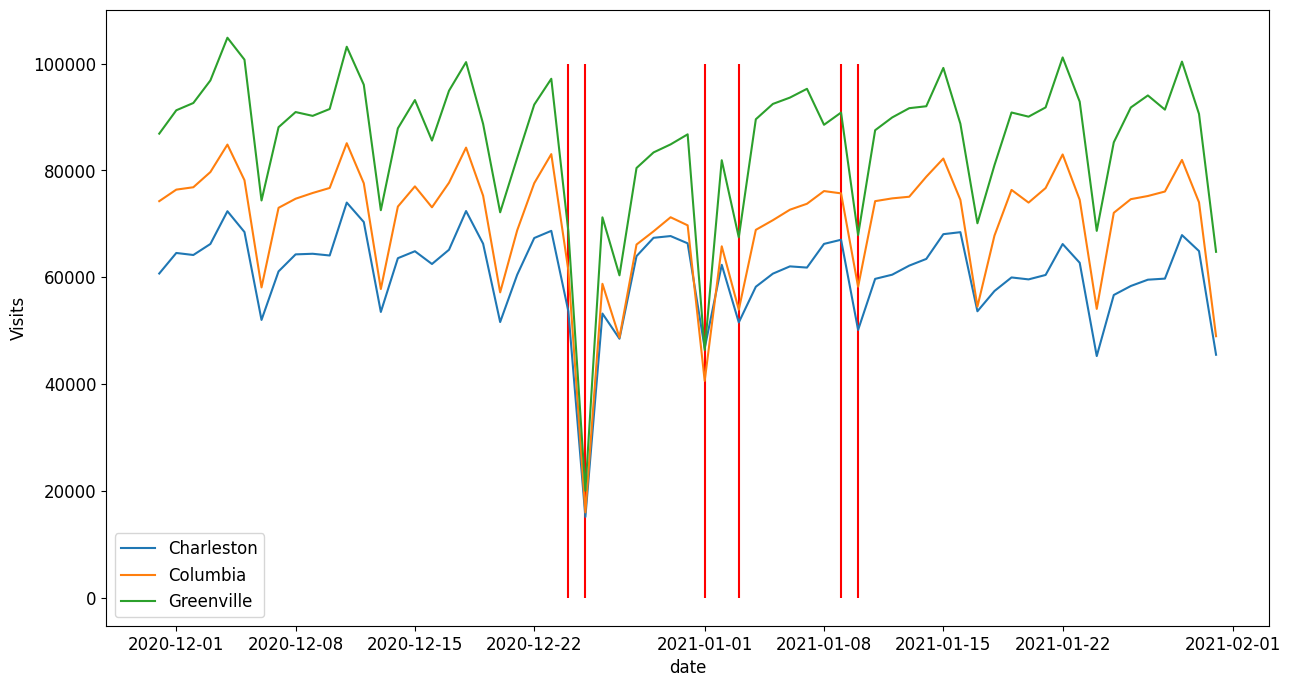

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('seaborn-whitegrid')
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({'font.size': 12})


fig, ax = plt.subplots(figsize=(15, 8))
ax.set_ylabel("Visits")
# df_all[['Charleston_visits', 'Columbia_visits', 'Greenville_visits']].iloc[:].plot(ax=ax)
df_all.plot(ax=ax)
ax.vlines("2020-12-25",ymin=0, ymax=100000, colors='r')
ax.vlines("2020-12-24",ymin=0, ymax=100000, colors='r')
ax.vlines("2021-01-01",ymin=0, ymax=100000, colors='r')
ax.vlines("2021-01-03",ymin=0, ymax=100000, colors='r')
ax.vlines("2021-01-10",ymin=0, ymax=100000, colors='r')
ax.vlines("2021-01-09",ymin=0, ymax=100000, colors='r')


plt.show()

In [133]:
df_all

,Charleston,Columbia,Greenville
date,,,
2020-11-30,60692,74239,86877
2020-12-01,64539,76396,91250
2020-12-02,64159,76843,92613
2020-12-03,66223,79687,96837
2020-12-04,72353,84829,104834
...,...,...,...
2021-01-27,59536,75204,94030
2021-01-28,59738,76041,91370
2021-01-29,67883,81958,100363


In [12]:
hourly_columns = [c for c in MSA_df.columns if "hourly_visits_" in c]
MSA_df[hourly_columns].sum(axis=1).sum()

4435936.944606414

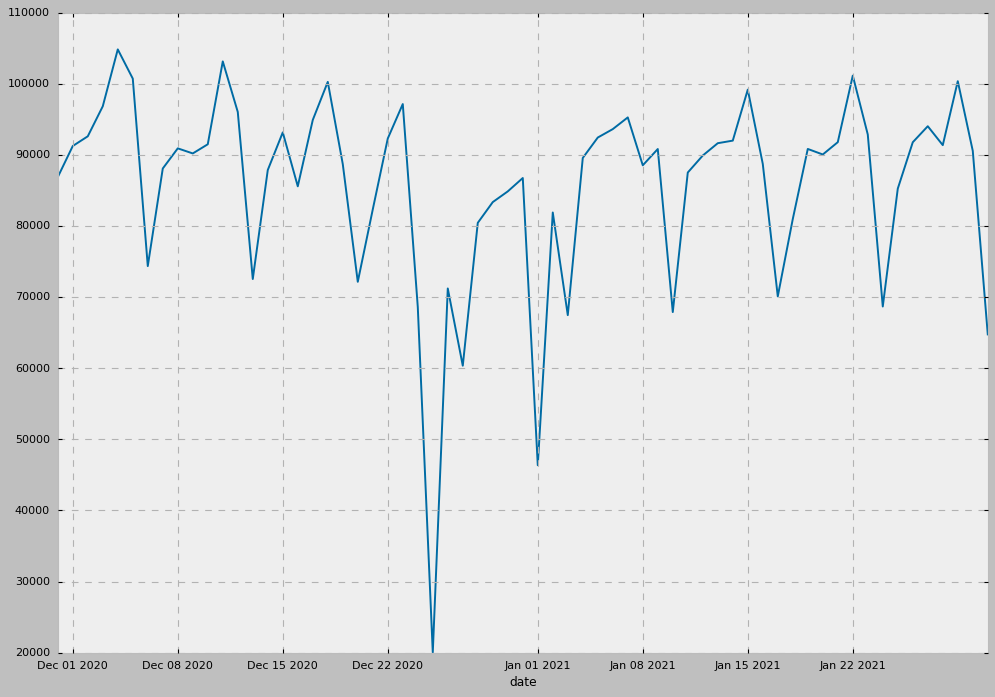

In [114]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))

df = MSA_df[hourly_columns].sum().transpose()#.plot()#.sum()#.fillna(0).sum(axis=1).sum()
df = pd.DataFrame(df).reset_index()
df.columns = ['hour', 'visits']
df['date'] = pd.to_datetime(df['hour'].str.replace('hourly_visits_', ''), format='%Y.%m.%d.%H')
df.groupby(df['date'].dt.date)['visits'].sum().plot(ax=ax)

plt.show()




## Visitation of each POI

In [185]:
df_list = []

for f in csv_files:
    for MSA in MSA_lists:
        if MSA in f:
            print(f)
            MSA_df = pd.read_csv(f)
            
            print(len(MSA_df))
            
            # hourly_df = MSA_df[hourly_columns].sum(axis=1)#.transpose()#.plot()#.sum()#.fillna(0).sum(axis=1).sum()
            # hourly_df.columns = ['visit_total']
            
            POI_attrubites_df = MSA_df.drop(columns=hourly_columns).iloc[:, :18]
            
            POI_attrubites_df['MSA_name'] = MSA
            POI_attrubites_df['visit_total'] = MSA_df[hourly_columns].sum(axis=1)
            
             # df['date'] = pd.to_datetime(df['hour'].str.replace('hourly_visits_', ''), format='%Y.%m.%d.%H')
            # df['MSA'] = MSA
            # gb_df = df.groupby(df['date'].dt.date)[f"{MSA}"].sum()# .plot(ax=ax)
            # gb_df = df
            
            df_list.append(POI_attrubites_df)


df_all = pd.concat(df_list)

df_all

H:\all_aggregate_data\stratified_by_metro_area\20201209_20210203\Charleston_North_Charleston_SC.csv
9975
H:\all_aggregate_data\stratified_by_metro_area\20201209_20210203\Columbia_SC.csv
10077
H:\all_aggregate_data\stratified_by_metro_area\20201209_20210203\Greenville_Anderson_SC.csv
12166


,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,city,region,postal_code,open_hours,polygon_class,area_square_feet,min_area,MSA_name,visit_total
0,sg:07c45d5488d944e791f65169a65161bb,NaN,Pride Gas,NaN,NaN,Gasoline Stations,Gasoline Stations with Convenience Stores,447110,33,-80,205 N Goose Creek Blvd,Goose Creek,SC,29445,NaN,OWNED_POLYGON,1619,1619,Charleston,217
1,sg:c656428a2bf74e84a88727b8039d8206,NaN,OnSite Appliance,NaN,NaN,Personal and Household Goods Repair and Mainte...,Appliance Repair and Maintenance,811412,33,-80,720 Magnolia Rd,Charleston,SC,29407,NaN,SHARED_POLYGON,2480,2480,Charleston,0
2,sg:e47e9359a1904670b93930ea48a70672,NaN,Azalea Park,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190,33,-80,107 W 5th North St,Summerville,SC,29483,"{ ""Mon"": [[""5:00"", ""22:00""]], ""Tue"": [[""5:00"",...",OWNED_POLYGON,54714,54714,Charleston,815
3,sg:7b7d0469cd754f6d942490c38e10e2cf,NaN,St Mark United Methodist Church,NaN,NaN,Religious Organizations,Religious Organizations,813110,33,-81,1201 Saint Mark Bowman Rd,Saint George,SC,29477,NaN,OWNED_POLYGON,247,247,Charleston,1
4,sg:9ce86f4a05514c9ebeb702b56f15e2d1,NaN,Waffle House,SG_BRAND_7d55f8ddf947e2b4446a8240c916ae25,Waffle House,Restaurants and Other Eating Places,Full-Service Restaurants,722511,33,-80,2571 Ashley,North Charleston,SC,29418,NaN,OWNED_POLYGON,222,222,Charleston,747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12161,sg:964c4dd6e9684886a6aaa489d4e493fa,NaN,Church Of God Of Prophecy Bible Place,NaN,NaN,Religious Organizations,Religious Organizations,813110,35,-82,510 Pendleton Rd,Parker,SC,29611,NaN,NaN,289,289,Greenville,54
12162,sg:110be4a29b30424a9bab40c71a2d7e05,NaN,Waffle House,SG_BRAND_7d55f8ddf947e2b4446a8240c916ae25,Waffle House,Restaurants and Other Eating Places,Full-Service Restaurants,722511,35,-83,7505 Highway 76,Pendleton,SC,29670,NaN,OWNED_POLYGON,132,132,Greenville,1281
12163,sg:eb04a0351d3c4b3f96eebb645d4a33d2,NaN,Mike & Jack 3,NaN,NaN,Gasoline Stations,Gasoline Stations with Convenience Stores,447110,35,-82,430 SE Main St,Simpsonville,SC,29681,NaN,NaN,863,863,Greenville,496
12164,sg:849139aca2f64d46adbd50572070bd92,NaN,CubeSmart,SG_BRAND_3609f80e8ab3db987d9be5010a726c20,CubeSmart,Lessors of Real Estate,Lessors of Miniwarehouses and Self-Storage Units,531130,35,-83,205 E West Pkwy,Anderson,SC,29621,"{ ""Mon"": [[""9:30"", ""18:00""]], ""Tue"": [[""9:30"",...",SHARED_POLYGON,3781,3781,Greenville,15


In [186]:
df_all.to_csv(r'H:\all_aggregate_data\stratified_by_metro_area\20201209_20210203\POI_visitation_count.csv', index=False)

In [192]:
df_all.iloc[:, -2:].groupby('MSA_name').sum()

,visit_total
MSA_name,
Charleston,3825345
Columbia,4435937
Greenville,5397442
